# Project 3

In [26]:
#IMPORTS
import pickle
import gzip
from PIL import Image
import os
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.datasets import make_classification
from sklearn import svm
import keras
import tensorflow as tf
import matplotlib.pyplot as graphPlot
%matplotlib inline


# Data Pre- Processing

In [27]:
def getPreProcessedData():
    # Pre-processing MNIST Data
    filename = 'mnist.pkl.gz'
    with open(filename, 'rb') as f:
        MNIST_Training, MNIST_Validation, MNIST_Testing = pickle.load(f, encoding='latin1')

    #Pre-processing USPS Data
    curPath  = 'USPSdata/Numerals'
    savedImg = []
    USPS_Testing_Data  = []
    USPS_Testing_Target  = []
    for j in range(0,10):
        curFolderPath = curPath + '/' + str(j)
        imgs =  os.listdir(curFolderPath)
        for img in imgs:
            curImg = curFolderPath + '/' + img
            if curImg[-3:] == 'png':
                img = Image.open(curImg,'r')
                img = img.resize((28, 28))
                savedImg = img
                imgdata = (255-np.array(img.getdata()))/255
                USPS_Testing_Data.append(imgdata)
                USPS_Testing_Target.append(j)
    return MNIST_Training, MNIST_Validation, MNIST_Testing, USPS_Testing_Data, USPS_Testing_Target



# Preparing DataSets

In [28]:
MNIST_Training, MNIST_Validation, MNIST_Testing, USPS_Testing_Data, USPS_Testing_Target = getPreProcessedData()
MNIST_Training_Features = np.append(MNIST_Training[0],MNIST_Validation[0], axis = 0)
MNIST_Training_Target = np.append(MNIST_Training[1],MNIST_Validation[1], axis = 0)

# Multilayer Percepton Nueral Network

In [29]:
def RunMLPModel(X,Y):
    classifier = MLPClassifier(activation='logistic', alpha=1e-05, batch_size='auto',beta_1=0.9, beta_2=0.999,
                 early_stopping=False, epsilon=1e-08, hidden_layer_sizes=(256, 4),learning_rate='adaptive', 
                 learning_rate_init=0.01,max_iter = 200, momentum=0.6, n_iter_no_change=10, nesterovs_momentum=True,
                 power_t=0.5, random_state=1, shuffle=True, solver='sgd', tol=0.0001,validation_fraction=0.15, 
                 verbose=False, warm_start=False)
    classifier.fit(X, Y)                         
    return classifier
    


# Random Forest Model

In [46]:
def RunRFModel(X,Y):
    classifier = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                 max_depth=5, max_features='auto', max_leaf_nodes=None,
                 min_impurity_decrease=0.0, min_impurity_split=None,
                 min_samples_leaf=1, min_samples_split=4,
                 min_weight_fraction_leaf=0.0, n_estimators=120, n_jobs=None,
                 oob_score=False, random_state=0, verbose=0, warm_start=False)
    classifier.fit(X,Y)
    return classifier


# Support Vector Machines


In [38]:
def RunSVMModel(X,Y):
    Classifier =  svm.SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
    Classifier.fit(X, Y)    
    return Classifier

# Multi-Class Logistic Regression

In [65]:
def RunMCLRModel(MNIST_Training_Features, MNIST_Training_Target):
    MNIST_Training_One_Hot = keras.utils.to_categorical(MNIST_Training_Target)
    Weights = np.zeros((MNIST_Training_Features.shape[1],MNIST_Training_One_Hot.shape[1]))
    MNIST_Training_Samples = len(MNIST_Training[0])
    LearningRate = 0.05
    Epochs = 500
    batchSize = 128
    Weights, CostList = GradientDescent(MNIST_Training_Samples,Weights,MNIST_Training_Features,MNIST_Training_One_Hot,LearningRate,Epochs)
    graphPlot.plot([i for i in range(Epochs)],CostList,'b.',label = 'Epochs Vs Cost')
    return Weights

In [66]:
def SoftMaxFunction(X, W):
    Product = np.matmul(X, W)
    Temp = np.exp(Product - np.max(Product))
    softmax = (Temp.T / np.sum(Temp)).T
    return softmax

def CostFunction(M,X,W,T):
    J = (-1/M)*np.sum(T * np.log(SoftMaxFunction(X,W)))
    return J

def GradientDescent(M,W,X,T, LearningRate,Epochs):
    costs = [0]* Epochs
    for i in range(0,Epochs):
        W = W - (LearningRate/M) * np.dot(X.T,(SoftMaxFunction(X,W) - T))
        cost = CostFunction(M,X,W,T)
        costs[i] = cost
    return W, costs

def getPredictedDigits(PredictedResult):
    PredictedDigits = np.zeros(len(PredictedResult))
    for p in range(0,len(PredictedResult)):
        maxProbablity =0
        ProbableDigit = 0
        for i in range(0,9):
            if(PredictedResult[p][i] >maxProbablity):
               maxProbablity = PredictedResult[p][i]
               ProbableDigit = i
        PredictedDigits[p] = ProbableDigit
    return PredictedDigits
        
    

# Computing Accuracy and Confusion Matrix

In [63]:
def CalculateAccuracy(predictedResult, Target):
    difference = predictedResult - Target
    AccuracyCount = sum(difference==0)
    return AccuracyCount/len(Target)

def GetConfusionMatrix(pedictedResult,Target):
    ConfusionMatrix = np.zeros((10,10))
    for i in range(0,len(Target)):   
        t = int(Target[i])
        p = int(pedictedResult[i])
        ConfusionMatrix[t][p] = int(ConfusionMatrix[t][p]+1)
    return ConfusionMatrix.astype(int)
        
    

# Testing Multi-layer Perceptron(MLP) Neural Network Model

In [17]:
#Multi-layer Perceptron(MLP) Neural Network Model
#Running the Model on MNIST Dataset
MLP_Model_Classifier = RunMLPModel(MNIST_Training_Features,MNIST_Training_Target)
#Validation on MNIST Data Set
MLP_MNIST_ValidationResult = MLP_Model_Classifier.predict(MNIST_Validation[0])
MLP_MNIST_ValidationAccuracy = CalculateAccuracy(MLP_MNIST_ValidationResult,MNIST_Validation[1])
#Testing the MLP Model on MNIST DataSet
MLP_MNISTpredictedResult = MLP_Model_Classifier.predict(MNIST_Testing[0])
MLP_MNIST_ConfusionMatrix = GetConfusionMatrix(MLP_MNISTpredictedResult,MNIST_Testing[1])
MLP_MNISTTestingAccuracy = CalculateAccuracy(MLP_MNISTpredictedResult,MNIST_Testing[1])
print("Multi-layer Perceptron(MLP) Neural Network Model")
print("MNIST Dataset ConfusionMatrix:")
print(MLP_MNIST_ConfusionMatrix)
print("MNIST Dataset Testing Accuracy:"+ str(MLP_MNISTTestingAccuracy))
print("MNIST Dataset Validation Accuracy:"+ str(MLP_MNIST_ValidationAccuracy))
#Testing the MLP Model USPS DataSet
MLP_USPSpredictedResult = MLP_Model_Classifier.predict(USPS_Testing_Data)
MLP_USPSTestingAccuracy = CalculateAccuracy(MLP_USPSpredictedResult,USPS_Testing_Target)
MLP_USPS_ConfusionMatrix = GetConfusionMatrix(MLP_USPSpredictedResult,USPS_Testing_Target)
print("USPS Dataset ConfusionMatrix:")
print(MLP_MNIST_ConfusionMatrix)
print("USPS Dataset Testing Accuracy:"+ str(MLP_USPSTestingAccuracy))

/anaconda3/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Multi-layer Perceptron(MLP) Neural Network Model
MNIST Dataset ConfusionMatrix:
[[ 956    0    0    1    0   12    8    2    1    0]
 [   0 1113   11    2    0    1    1    2    5    0]
 [   8   11  935   28    3    0   18    6   23    0]
 [   4    0   14  947    0   14    1   15   15    0]
 [   0    2    3    0  930    1   17    1    2   26]
 [  20    1    5   29    1  791   12    3   20   10]
 [  12    2    6    0    9   14  913    0    2    0]
 [   1   20   10   13    7    1    1  954    2   19]
 [   0    3    7   13   12   26    5    7  897    4]
 [   5    2    1    9   46   12    1   22    4  907]]
MNIST Dataset Testing Accuracy:0.9343
MNIST Dataset Validation Accuracy:0.9426
USPS Dataset ConfusionMatrix:
[[ 956    0    0    1    0   12    8    2    1    0]
 [   0 1113   11    2    0    1    1    2    5    0]
 [   8   11  935   28    3    0   18    6   23    0]
 [   4    0   14  947    0   14    1   15   15    0]
 [   0    2    3    0  930    1   17    1    2   26]
 [  20    1    

# Testing Random Forest (RF) Model

In [47]:
# Random Forest (RF) Model
#Running the Model on MNIST Dataset
RF_Model_Classifier = RunRFModel(MNIST_Training_Features,MNIST_Training_Target)
#Validation on MNIST Data Set
RF_MNIST_ValidationResult = RF_Model_Classifier.predict(MNIST_Validation[0])
RF_MNIST_ValidationAccuracy = CalculateAccuracy(RF_MNIST_ValidationResult,MNIST_Validation[1])
#Testing the RF Model on MNIST DataSet
RF_MNISTpredictedResult = RF_Model_Classifier.predict(MNIST_Testing[0])
RF_MNISTTestingAccuracy = CalculateAccuracy(RF_MNISTpredictedResult,MNIST_Testing[1])
RF_MNIST_ConfusionMatrix = GetConfusionMatrix(RF_MNISTpredictedResult,MNIST_Testing[1])
print("Random Forest Model")
print("MNIST Dataset ConfusionMatrix:")
print(RF_MNIST_ConfusionMatrix)
print("MNIST Dataset Testing Accuracy:"+ str(RF_MNISTTestingAccuracy))
print("MNIST Dataset Validation Accuracy:"+ str(RF_MNIST_ValidationAccuracy))
#Testing the RF Model on USPS DataSet
RF_USPSpredictedResult = RF_Model_Classifier.predict(USPS_Testing_Data)
RF_USPS_ConfusionMatrix = GetConfusionMatrix(RF_USPSpredictedResult,USPS_Testing_Target)
RF_USPSTestingAccuracy = CalculateAccuracy(RF_USPSpredictedResult,USPS_Testing_Target)
print("USPS Dataset ConfusionMatrix:")
print(RF_USPS_ConfusionMatrix)
print("USPS Dataset Testing Accuracy:"+ str(RF_USPSTestingAccuracy))

Random Forest Model
MNIST Dataset ConfusionMatrix:
[[ 961    1    2    1    0    1    3    4    7    0]
 [   0 1120    2    1    0    1    4    1    6    0]
 [  15   33  873   19   10    0   27   31   17    7]
 [  12   12   28  868    3   13    4   21   29   20]
 [   4    3    2    1  806    1   26    8   18  113]
 [  35   27    2  149   20  569   32   12   19   27]
 [  27   12    6    1   21   10  871    3    7    0]
 [   2   32   42    1    7    0    0  899    8   37]
 [   6   29    9   34   14   10   25    5  799   43]
 [  10   11    4   13   26    2    7   35   21  880]]
MNIST Dataset Testing Accuracy:0.8646
MNIST Dataset Validation Accuracy:0.8763
USPS Dataset ConfusionMatrix:
[[ 674  106   93   25  221   22   25  789    0   45]
 [  70  612   34   23   22   18   14 1200    3    4]
 [ 180  317  420   65   32   29   19  934    0    3]
 [ 112  150   35  686   96   79    9  807    2   24]
 [  18  445   11   18  449   38   11  997    1   12]
 [ 258  213   49  189   53  464   39  726   

# Testing Support Vector Machines(SVM) Model

In [40]:
# Support Vector Machines(SVM) Model
#Running SVM Model on MNIST Dataset
SVM_Model_Classifier = RunSVMModel(MNIST_Training_Features,MNIST_Training_Target)
#Validation on MNIST Data Set
SVM_MNIST_ValidationResult = SVM_Model_Classifier.predict(MNIST_Validation[0])
SVM_MNIST_ValidationAccuracy = CalculateAccuracy(SVM_MNIST_ValidationResult,MNIST_Validation[1])
#Testing the SVM Model on MNIST DataSet
SVM_MNISTpredictedResult = SVM_Model_Classifier.predict(MNIST_Testing[0])
SVM_MNISTTestingAccuracy = CalculateAccuracy(SVM_MNISTpredictedResult,MNIST_Testing[1])
SVM_MNIST_ConfusionMatrix = GetConfusionMatrix(SVM_MNISTpredictedResult,MNIST_Testing[1])
print("Support Vector Machines Model")
print("MNIST Dataset ConfusionMatrix:")
print(SVM_MNIST_ConfusionMatrix)
print("MNIST Dataset Testing Accuracy:"+ str(SVM_MNISTTestingAccuracy))
print("MNIST Dataset Validation Accuracy:"+ str(SVM_MNIST_ValidationAccuracy))
#Testing the SVM Model on USPS DataSet
SVM_USPSpredictedResult = SVM_Model_Classifier.predict(USPS_Testing_Data)
SVM_USPSTestingAccuracy = CalculateAccuracy(SVM_USPSpredictedResult,USPS_Testing_Target)
SVM_USPS_ConfusionMatrix = GetConfusionMatrix(SVM_USPSpredictedResult,USPS_Testing_Target)
print("Support Vector Machines Model")
print("USPS Dataset ConfusionMatrix:")
print(SVM_USPS_ConfusionMatrix)
print("USPS Dataset Testing Accuracy:"+ str(SVM_USPSTestingAccuracy))

Support Vector Machines Model
MNIST Dataset ConfusionMatrix:
[[ 969    0    2    0    0    4    2    1    2    0]
 [   0 1124    3    1    0    1    3    1    2    0]
 [   5    1  989    7    5    0    3   10   11    1]
 [   0    0    8  973    0    8    0    8    9    4]
 [   1    0    7    0  952    0    2    2    2   16]
 [   4    2    2   17    2  847    7    1    8    2]
 [   9    2    2    0    3    6  933    0    3    0]
 [   2   10   20    4    4    0    0  971    2   15]
 [   3    1    4   10    7    9    7    5  926    2]
 [   4    7    2   11   21    4    1    8    4  947]]
MNIST Dataset Testing Accuracy:0.9631
MNIST Dataset Validation Accuracy:0.9728
Support Vector Machines Model
USPS Dataset ConfusionMatrix:
[[ 609    1  436   21  197  290   53   62    6  325]
 [  77  397  327  147  172  183   42  623   22   10]
 [  98   10 1510   54   24  207   40   43    8    5]
 [  44    4  206 1209    3  459    2   51   14    8]
 [  14   32  147   17 1064  279   17  278   76   76]
 [  

# Testing Multi- Class Logistic Regression(MCLR) Model

Multi-Class Logistic Regression
MNIST Dataset ConfusionMatrix:
[[967   0   1   2   0   0   1   0   9   0]
 [  0 874   1  16   0   0   5   0 239   0]
 [113   1 716  66   4   0  31   5  96   0]
 [ 66   0  14 848   0   0   2   6  74   0]
 [ 78   0  13  26 580   0  58   2 225   0]
 [421   2  11 206   1   0  11   5 235   0]
 [182   2  11   2   1   0 725   0  35   0]
 [ 63  10  21  15   2   0   2 797 118   0]
 [ 70   0   4  91   1   0  11   3 794   0]
 [134   1  11  74 126   0   7 176 480   0]]
MNIST Dataset Testing Accuracy:0.6301
MNIST Dataset Validation Accuracy:0.6474
USPS Dataset ConfusionMatrix:
[[1502    0  243   50   75    0   16   11  103    0]
 [ 516  114  223  262   17    0   28  309  531    0]
 [ 886    8  749   94    6    0   55   26  175    0]
 [ 896    0   59  811    1    0   19   16  198    0]
 [ 696   28   77  137  394    0   34  136  498    0]
 [1235    5  143  296    2    0   52   19  248    0]
 [1423    3  192   39   26    0  235    4   78    0]
 [ 486  115  365  361    4

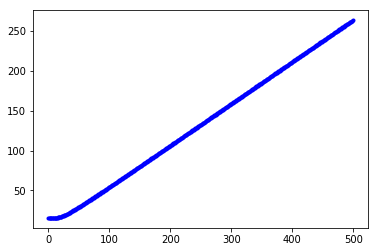

In [67]:
#Multi- Class Logistic Regression(MCLR) Model
#Running the Multi- Class Logistic Regression(MCLR) Model
MCLR_Weights = RunMCLRModel(MNIST_Training_Features,MNIST_Training_Target)
#Testing the MCLR Model on MNIST DataSet
MCLR_MNIST_PredictedProbablity = SoftMaxFunction(MNIST_Testing[0],MCLR_Weights)
MCLR_MNISTpredictedResult = getPredictedDigits(MCLR_MNIST_PredictedProbablity)
MCLR_MNIST_ValidationProbablity = SoftMaxFunction(MNIST_Validation[0],MCLR_Weights)
MCLR_MNIST_ValidationResult = getPredictedDigits(MCLR_MNIST_ValidationProbablity)
MCLR_MNIST_ValidationAccuracy = CalculateAccuracy(MCLR_MNIST_ValidationResult,MNIST_Validation[1])
MCLR_MNISTTestingAccuracy = CalculateAccuracy(MCLR_MNISTpredictedResult,MNIST_Testing[1])
MCLR_MNIST_ConfusionMatrix = GetConfusionMatrix(MCLR_MNISTpredictedResult,MNIST_Testing[1])
print("Multi-Class Logistic Regression")
print("MNIST Dataset ConfusionMatrix:")
print(MCLR_MNIST_ConfusionMatrix)
print("MNIST Dataset Testing Accuracy:"+ str(MCLR_MNISTTestingAccuracy))
print("MNIST Dataset Validation Accuracy:"+ str(MCLR_MNIST_ValidationAccuracy))
#Testing the MCLR Model on USPS DataSet
MCLR_USPS_PredictedProbablity = SoftMaxFunction(USPS_Testing_Data,MCLR_Weights)
MCLR_USPSpredictedResult = getPredictedDigits(MCLR_USPS_PredictedProbablity)
MCLR_USPS_TestingAccuracy = CalculateAccuracy(MCLR_USPSpredictedResult,USPS_Testing_Target) 
MCLR_USPS_ConfusionMatrix = GetConfusionMatrix(MCLR_USPSpredictedResult,USPS_Testing_Target)
print("USPS Dataset ConfusionMatrix:")
print(MCLR_USPS_ConfusionMatrix)
print("MNIST Dataset Testing Accuracy:"+ str(MCLR_USPS_TestingAccuracy))


# Ensemble Voting Classifier

In [49]:
MLP_Model_Classifier =  MLPClassifier(activation='logistic', alpha=1e-05, batch_size='auto',beta_1=0.9, beta_2=0.999, 
                        early_stopping=False,epsilon=1e-08, hidden_layer_sizes=(1000, 4),learning_rate='adaptive', 
                        learning_rate_init=0.01,max_iter = 200, momentum=0.6, n_iter_no_change=10,
                        nesterovs_momentum=True, power_t=0.5,random_state=1,shuffle=True, solver='sgd', tol=0.0001,
                        validation_fraction=0.15, verbose=False, warm_start=False)
RF_Model_Classifer = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini', max_depth=2, 
                     max_features=784, max_leaf_nodes=None,min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,min_weight_fraction_leaf=0.0, n_estimators=100, 
                     n_jobs=None,oob_score=False, random_state=0, verbose=0, warm_start=False)
SVM_Model_Classifer = svm.SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,decision_function_shape='ovr',
                      degree=3, gamma='scale', kernel='rbf',max_iter=-1, probability=False, random_state=None, 
                      shrinking=True,tol=0.001, verbose=False)
Ensemble_Voting_Classifier = VotingClassifier(estimators=[('MLP', MLP_Model_Classifier), ('RF', RF_Model_Classifer), ('SVM', SVM_Model_Classifer)],
                                              voting='hard',weights=[1,1,2],flatten_transform=True)
print('Ensemble_Voting_Classifier created')
Ensemble_Voting_Classifier.fit(MNIST_Training_Features[0:2000,],MNIST_Training_Target[0:2000])
#Testing on MNIST Dataset
EnsemblePredictedResults = Ensemble_Voting_Classifier.predict(MNIST_Testing[0][0:100,])
Ensemble_ConfusionMatrix = GetConfusionMatrix(EnsemblePredictedResults,MNIST_Testing[1][0:100])
Ensemble_TestingAccuracy = CalculateAccuracy(EnsemblePredictedResults,MNIST_Testing[1][0:100])
print("Ensemble Voting Classifier Model")
print("MNIST Dataset Confusion Matrix")
print(Ensemble_ConfusionMatrix)
print("MNIST Dataset Testing Accuracy " + str(Ensemble_TestingAccuracy))



Ensemble_Voting_Classifier created


/anaconda3/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


KeyboardInterrupt: 